In [11]:
# Install fairness toolkit
!pip install fairlearn matplotlib pandas scikit-learn seaborn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    equalized_odds_ratio,
    selection_rate,
    true_positive_rate,
    false_positive_rate
)


In [13]:
# Load dataset from uploaded CSV file
import pandas as pd

# Update this path if necessary (Colab will usually place it in /content/)
df = pd.read_csv('adult.csv')

# Display first few rows
df.head()


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [14]:
# Replace "?" with NaN and drop missing values
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

# Identify features and target
target = 'income'
X = df.drop(columns=[target])
y = df[target]

# Encode categorical variables
cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Encode target variable
y = y.map({'>50K': 1, '<=50K': 0})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8183224665708918

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      6754
           1       0.73      0.45      0.56      2295

    accuracy                           0.82      9049
   macro avg       0.78      0.70      0.72      9049
weighted avg       0.81      0.82      0.80      9049



In [16]:
# Extract sensitive attributes
sensitive_features_sex = df.loc[y_test.index, 'sex']
sensitive_features_race = df.loc[y_test.index, 'race']

# Compute metrics per group
mf_sex = MetricFrame(
    metrics={
        'selection_rate': selection_rate,
        'TPR': true_positive_rate,
        'FPR': false_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_features_sex
)

mf_race = MetricFrame(
    metrics={
        'selection_rate': selection_rate,
        'TPR': true_positive_rate,
        'FPR': false_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_features_race
)

print("=== Fairness Metrics by Sex ===")
print(mf_sex.by_group)

print("\n=== Fairness Metrics by Race ===")
print(mf_race.by_group)


=== Fairness Metrics by Sex ===
        selection_rate       TPR       FPR
sex                                       
Female         0.03646  0.208955  0.013253
Male           0.21401  0.496429  0.084193

=== Fairness Metrics by Race ===
                    selection_rate       TPR       FPR
race                                                  
Amer-Indian-Eskimo        0.079208  0.500000  0.011494
Asian-Pac-Islander        0.171756  0.440000  0.064171
Black                     0.066106  0.356522  0.019526
Other                     0.013514  0.142857  0.000000
White                     0.170437  0.461132  0.064080


In [17]:
# Demographic Parity
dp_diff_sex = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_features_sex)
dp_ratio_sex = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_features_sex)

# Equalized Odds
eo_diff_sex = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_features_sex)
eo_ratio_sex = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_features_sex)

print("=== Demographic Parity (Sex) ===")
print(f"Difference: {dp_diff_sex:.4f}")
print(f"Ratio: {dp_ratio_sex:.4f}")

print("\n=== Equalized Odds (Sex) ===")
print(f"Difference: {eo_diff_sex:.4f}")
print(f"Ratio: {eo_ratio_sex:.4f}")


=== Demographic Parity (Sex) ===
Difference: 0.1776
Ratio: 0.1704

=== Equalized Odds (Sex) ===
Difference: 0.2875
Ratio: 0.1574


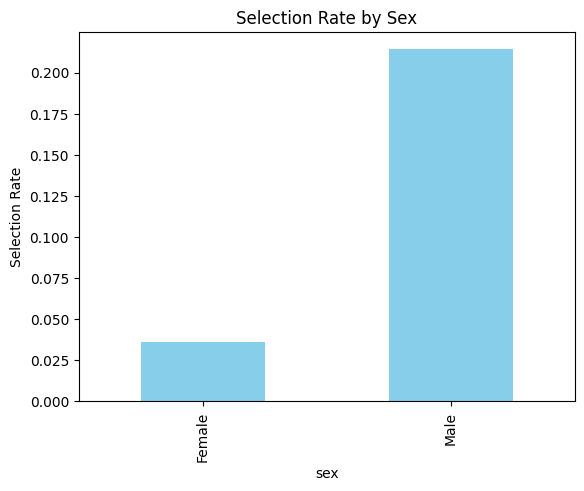

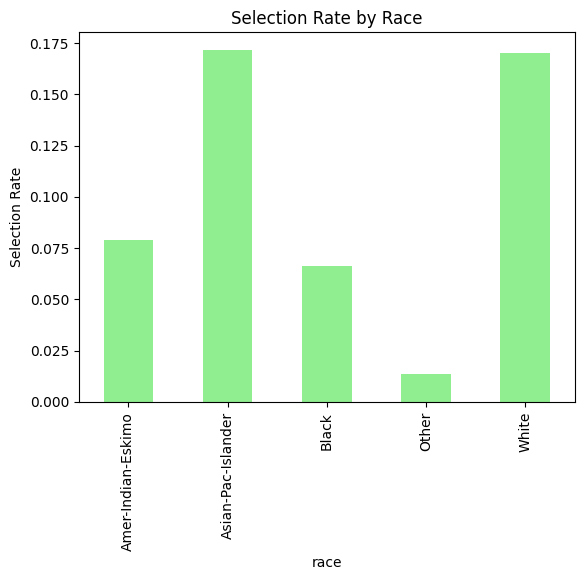

In [18]:
# Plot selection rates
mf_sex.by_group['selection_rate'].plot(kind='bar', color='skyblue')
plt.title('Selection Rate by Sex')
plt.ylabel('Selection Rate')
plt.show()

mf_race.by_group['selection_rate'].plot(kind='bar', color='lightgreen')
plt.title('Selection Rate by Race')
plt.ylabel('Selection Rate')
plt.show()
